In [21]:
# pip install torch torchvision matplotlib
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.cluster import KMeans

In [2]:
# ---- Config ----
latent_dim = 8      # try 2, 3, 8, 16
beta = 1.0           # try 2.0 or 4.0 for β-VAE
epochs = 10
batch_size = 128
lr = 1e-3
prior_var = 1  # change this to experiment
prior_logvar = math.log(prior_var)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# ---- Data ----
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root="../data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="../data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [4]:
# ---- Model ----
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
        )
        self.mu = nn.Linear(256, latent_dim)
        self.logvar = nn.Linear(256, latent_dim)

    def forward(self, x):
        h = self.net(x)
        return self.mu(h), self.logvar(h)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, 28*28),
        )

    def forward(self, z):
        x = self.net(z)
        return torch.sigmoid(x).view(-1, 1, 28, 28)

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.enc = Encoder(latent_dim)
        self.dec = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        mu, logvar = self.enc(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.dec(z)
        return x_hat, mu, logvar

def loss_fn(x, x_hat, mu, logvar, beta=1.0):
    recon = F.binary_cross_entropy(x_hat, x, reduction='sum') / x.size(0)
    # KL for diagonal Gaussians
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon + beta * kl, recon, kl


In [5]:
model = VAE(latent_dim).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=lr)

In [6]:
# ---- Train ----
for epoch in range(1, epochs+1):
    model.train()
    total, recon_t, kl_t = 0, 0, 0
    for x, _ in train_loader:
        x = x.to(device)
        x_hat, mu, logvar = model(x)
        loss, recon, kl = loss_fn(x, x_hat, mu, logvar, beta)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item(); recon_t += recon.item(); kl_t += kl.item()
    print(f"Epoch {epoch:02d}: loss={total/len(train_loader):.2f}  recon={recon_t/len(train_loader):.2f}  kl={kl_t/len(train_loader):.2f}")

Epoch 01: loss=170.40  recon=162.68  kl=7.72
Epoch 02: loss=126.97  recon=113.89  kl=13.08
Epoch 03: loss=119.06  recon=104.76  kl=14.30
Epoch 04: loss=114.79  recon=99.73  kl=15.07
Epoch 05: loss=112.36  recon=96.94  kl=15.42
Epoch 06: loss=110.65  recon=95.02  kl=15.63
Epoch 07: loss=109.40  recon=93.60  kl=15.80
Epoch 08: loss=108.39  recon=92.45  kl=15.94
Epoch 09: loss=107.56  recon=91.52  kl=16.04
Epoch 10: loss=106.88  recon=90.73  kl=16.15


In [8]:
model.eval()

VAE(
  (enc): Encoder(
    (net): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=256, bias=True)
      (4): ReLU()
    )
    (mu): Linear(in_features=256, out_features=8, bias=True)
    (logvar): Linear(in_features=256, out_features=8, bias=True)
  )
  (dec): Decoder(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=784, bias=True)
    )
  )
)

In [16]:
latent_vectors = None
latent_vectors_labels = None
for x , _ in train_loader:
    x = x.to(device)
    mu , logvar = model.enc(x)
    if(latent_vectors is None):
        latent_vectors = mu
        latent_vectors_labels = _
    else:
        latent_vectors = torch.cat((latent_vectors, mu) , dim=0)
        latent_vectors_labels = torch.cat((latent_vectors_labels,_) , dim=0)
    # l

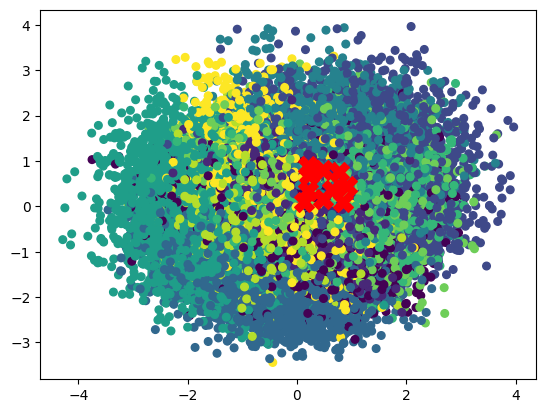

In [26]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Example data (2D points)
X = np.random.rand(100, 2)  # shape: [100 samples, 2 features]

# Run KMeans with 3 clusters
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X)

# Get cluster assignments and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Visualization
with torch.no_grad():
    plt.scatter(latent_vectors[:, 0].cpu(), latent_vectors[:, 1].cpu(), c=latent_vectors_labels, cmap='viridis', s=30)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200)
    plt.show()
